In this project I will be predicting whether the order will be cancelled based on product features, price, shipment destination, sales channel and other features available in data set. 

I will be using 2 tables from E-Commerce Sales Dataset here: https://www.kaggle.com/datasets/thedevastator/unlock-profits-with-e-commerce-sales-data/data (Amazon Sale Report & Sale Report).

In [1]:
#Importing libraries
import numpy as np # numpy==1.24.1
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt

/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
#Loading Amazon sales report data first
sales_data = pd.read_csv('Amazon Sale Report.csv', parse_dates=['Date'])

/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_10379/2573508680.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data = pd.read_csv('Amazon Sale Report.csv', parse_dates=['Date'])
/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_10379/2573508680.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales_data = pd.read_csv('Amazon Sale Report.csv', parse_dates=['Date'])


In [4]:
#Checking how data looks like
sales_data.head()

index             Order ID       Date                        Status  \
0      0  405-8078784-5731545 2022-04-30                     Cancelled   
1      1  171-9198151-1101146 2022-04-30  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146 2022-04-30                       Shipped   
3      3  403-9615377-8133951 2022-04-30                     Cancelled   
4      4  407-1069790-7240320 2022-04-30                       Shipped   

  Fulfilment Sales Channel  ship-service-level    Style              SKU  \
0   Merchant      Amazon.in           Standard   SET389   SET389-KR-NP-S   
1   Merchant      Amazon.in           Standard  JNE3781  JNE3781-KR-XXXL   
2     Amazon      Amazon.in          Expedited  JNE3371    JNE3371-KR-XL   
3   Merchant      Amazon.in           Standard    J0341       J0341-DR-L   
4     Amazon      Amazon.in          Expedited  JNE3671  JNE3671-TU-XXXL   

        Category  ... currency  Amount    ship-city   ship-state  \
0            Set  ...      INR  647.62       MUMBAI  MAHARASHTRA   
1          kurta  ...      INR  406.00    BENGALURU    KARNATAKA   
2          kurta  ...      INR  329.00  NAVI MUMBAI  MAHARASHTRA   
3  Western Dress  ...      INR  753.33   PUDUCHERRY   PUDUCHERRY   
4            Top  ...      INR  574.00      CHENNAI   TAMIL NADU   

  ship-postal-code  ship-country  \
0         400081.0            IN   
1         560085.0            IN   
2         410210.0            IN   
3         605008.0            IN   
4         600073.0            IN   

                                       promotion-ids    B2B  fulfilled-by  \
0                                                NaN  False     Easy Ship   
1  Amazon PLCC Free-Financing Universal Merchant ...  False     Easy Ship   
2       IN Core Free Shipping 2015/04/08 23-48-5-108   True           NaN   
3                                                NaN  False     Easy Ship   
4                                                NaN  False           NaN   

  Unnamed: 22  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

[5 rows x 24 columns]

In [5]:
#Checking null values and data types for each column
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   index               128975 non-null  int64         
 1   Order ID            128975 non-null  object        
 2   Date                128975 non-null  datetime64[ns]
 3   Status              128975 non-null  object        
 4   Fulfilment          128975 non-null  object        
 5   Sales Channel       128975 non-null  object        
 6   ship-service-level  128975 non-null  object        
 7   Style               128975 non-null  object        
 8   SKU                 128975 non-null  object        
 9   Category            128975 non-null  object        
 10  Size                128975 non-null  object        
 11  ASIN                128975 non-null  object        
 12  Courier Status      122103 non-null  object        
 13  Qty                 128975 no

# Data profiling

In [6]:
#Data profiling for Amazon Sale Report dataframe
profile = ProfileReport(sales_data, title="Profiling Report")

profile 

#Seems like after data profiling 'index' column changes its name to 'df_index'. Need to understand why. 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Observations as a result of data profiling

1. Need to drop 'index' column.
2. 'Order ID' is not unique - are these duplicates, or are these just different products purchased within one order and recorded as separate rows?
2. 'Date' - we have almost 3 months of data. The earliest date is Mar 31, 2022, the latest is Jun 29, one day of Jun is missing, otherwise, there are no gaps in data. Seems like in May-Jun there are fewer records than in Apr (did sales volume decrease?). There seems to be a seasonality trend - smaller order volume on some days during the week (assuming, on weekends). Will need to add weekday / weekend column.
3. 'Status' - it is my potential target feature. There are several values for ’Shipped’ status - perhaps they could be grouped. The orders with the status ‘Shipped - Returning to Seller’ and ’Shipped - Rejected by Buyer’ are not technically ‘Cancelled' orders, but are similar in terms of the negative impact they have on the business. I’ll need to decide whether to group these records with ‘Cancellations’, with ’Shipped’ orders, or remove them altogether (as a part of a different problem to solve). 
4. 'Fulfillment' - is highly correlated with the ‘ship-service-level’ column. Perhaps, Merchant will have a different shipping service than Amazon (will need to verify).
5. 'Sales channel' - most of the records are for Amazon with only 124 records for Non-Amazon. Highly correlated with 'Amount' column. 
6. 'ship-service-level' - highly correlated with ‘Fulfillment' and 'Status' columns. Will need to explore more.
7. 'style' - has 1,377 distinct values.
8. 'SKU' - has 7,195 distinct values.
9. 'Category' - has 9 distinct values.
10. 'Size' - has 11 distinct values.
11. 'ASIN' - has 7,190 distinct values, a similar number to SKU. I wonder what is the difference between SKU & ASIN. I. might need to drop one of these columns.
12. 'Courier status' - has only 3 values, this also could be my target feature (instead of 'Status'), but 6,872 values are missing. Need to check what is the overlap with the 'Status' column.
13. 'Qty' -  10% of records have 0 quantity. How is it possible to order 0 number of items? Are these missing values? It's highly correlated with 'Courier status'. Need to investigate further regarding 0 values and decide  whether to drop the column, since most of the values are 1.
14. 'currency' - all values are 'INR' and 6% of values are missing. Probably will need to drop this column.
15. 'Amount' - 6% of values are missing (same records as missing values for currency). 2% of records have 0 amount (meaning the order was free) - what are these orders? Is there an overlap with records where the quantity is 0? Also, need to decide whether to calculate the amount in USD. Will need to add price per item.
16. 'ship-city' - has 8,955 distinct values, 33 values are missing. Need to check if there’s a pattern for missing values and then no harm in dropping null value records (since there are only a few of them).
17. 'ship-state' - 69 distinct values. India has 28 states + 8 territories = 36 in total. Will need to make the values uniform. 33 values are missing (same records as the ones missing 'ship-city' values).
18. 'ship-postal-code' - has 9,459 distinct values, 33 values are missing (same records). Will need to change the data type to string.
19. 'ship-country' - can be dropped, it’s constant.
20. 'promotion-ids' - has 5,787 distinct values. 38% of values missing - assuming this is due to no promotion for that product. There are cases when the order has several promotions separated by a comma. I might need to split those promotions into separate boolean type features.
21. 'B2B' - only 871 orders are B2B with the rest orders B2C.
22. 'fulfilled-by' - there’s only 1 value ('Easy Ship'), and the majority of values (69.5%) are missing. Looks like this should be a boolean type feature for Easy Ship with a value of 1 for Easy Ship and 0 for a null value.
23. 'Unnamed: 22' - no information here, needs to be dropped.

# Data Wrangling

In [7]:
sales_data = pd.read_csv('Amazon Sale Report.csv', parse_dates=['Date'])

/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_10379/3634835127.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data = pd.read_csv('Amazon Sale Report.csv', parse_dates=['Date'])
/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_10379/3634835127.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales_data = pd.read_csv('Amazon Sale Report.csv', parse_dates=['Date'])


In [8]:
# Dropping the columns we don't need: index, Unnamed: 22, ship-country, currency
sales_data.drop(columns = ['index', 'Unnamed: 22', 'ship-country', 'currency'], inplace=True) 

In [9]:
# Renaming columns
sales_data_clean = pd.DataFrame(sales_data.rename(columns={'Date':'Order Date','Fulfilment':'Fulfilment By','ship-service-level':'Shipment Type','ship-city':'Shipment City', 'ship-state':'Shipment State','ship-postal-code':'Shipment Postal Code','promotion-ids':'Promotions','fulfilled-by':'Easy Ship'}))

In [10]:
# Checking whether non-unique 'Order IDs' are duplicated records. 
duplicates = sales_data_clean.duplicated()
sales_data_clean[duplicates]

Order ID Order Date     Status Fulfilment By Sales Channel   \
30661  406-0372545-6086735 2022-04-12  Cancelled        Amazon      Amazon.in   
41292  408-0373839-4433120 2022-04-05  Cancelled        Amazon      Amazon.in   
79845  171-9628368-5329958 2022-05-07  Cancelled        Amazon      Amazon.in   
85791  171-3249942-2207542 2022-05-03    Shipped        Amazon      Amazon.in   
86419  405-8669298-3850736 2022-05-03    Shipped        Amazon      Amazon.in   
98955  407-4853873-4978725 2022-06-22    Shipped        Amazon      Amazon.in   

      Shipment Type    Style              SKU Category Size        ASIN  \
30661     Expedited   SET197   SET197-KR-NP-L      Set    L  B08B3YPD63   
41292     Expedited  JNE3501     JNE3501-KR-M    kurta    M  B08MYVCDB4   
79845     Expedited    J0329       J0329-KR-L    kurta    L  B09KXRB7JV   
85791     Expedited   SET323  SET323-KR-NP-XL      Set   XL  B09NDKKM7P   
86419     Expedited  MEN5025  MEN5025-KR-XXXL    kurta  3XL  B08YYQS8FH   
98955     Expedited    J0230      J0230-SKD-M      Set    M  B08XNJG8B1   

      Courier Status  Qty  Amount Shipment City Shipment State  \
30661      Cancelled    0     NaN      Siliguri    WEST BENGAL   
41292      Cancelled    0     NaN     BENGALURU      KARNATAKA   
79845      Cancelled    0     NaN     ERNAKULAM         KERALA   
85791        Shipped    1   939.0          PUNE    MAHARASHTRA   
86419        Shipped    1   533.0     GHAZIABAD  UTTAR PRADESH   
98955        Shipped    1  1163.0      Zirakpur         Punjab   

       Shipment Postal Code                                    Promotions  \
30661              734008.0                                           NaN   
41292              560072.0                                           NaN   
79845              682017.0                                           NaN   
85791              411057.0  IN Core Free Shipping 2015/04/08 23-48-5-108   
86419              201010.0  IN Core Free Shipping 2015/04/08 23-48-5-108   
98955              140603.0  IN Core Free Shipping 2015/04/08 23-48-5-108   

         B2B Easy Ship  
30661  False       NaN  
41292  False       NaN  
79845  False       NaN  
85791  False       NaN  
86419  False       NaN  
98955  False       NaN

There are 6 duplicated records.

In [11]:
# Removing duplicates
sales_data_clean.drop_duplicates(inplace=True)

In [12]:
# Checking if we still have duplicated order ids.
# Some assumptions here:
# 1. Ordering few different products within same order could result in multiple records for the same order ID (but different product SKU)
# 2. Changing order status from 'Shipped' to 'Cancelled' / 'Returned' could result in multiple records for the same order ID (but different status)
(sales_data_clean['Order ID'] + ' , ' + sales_data_clean['SKU'] + ' , ' + sales_data_clean['Style'] + ' , ' + sales_data_clean['Status']).value_counts().head()

407-8364731-6449117 , JNE3769-KR-L , JNE3769 , Shipped        2
405-8078784-5731545 , SET389-KR-NP-S , SET389 , Cancelled     1
404-0736546-2435545 , JNE3291-KR-L , JNE3291 , Shipped        1
407-6930896-8975500 , SET233-KR-PP-XXXL , SET233 , Shipped    1
402-3396072-0120328 , JNE3554-KR-XXL , JNE3554 , Shipped      1
Name: count, dtype: int64

In [13]:
# Checking data for the order id with two records for the same product, style and order status.
sales_data_clean[sales_data_clean['Order ID']=='407-8364731-6449117']

Order ID Order Date   Status Fulfilment By Sales Channel   \
52330  407-8364731-6449117 2022-05-29  Shipped        Amazon      Amazon.in   
52331  407-8364731-6449117 2022-05-29  Shipped        Amazon      Amazon.in   
52332  407-8364731-6449117 2022-05-29  Shipped        Amazon      Amazon.in   
52333  407-8364731-6449117 2022-05-29  Shipped        Amazon      Amazon.in   
52334  407-8364731-6449117 2022-05-29  Shipped        Amazon      Amazon.in   

      Shipment Type    Style              SKU Category Size        ASIN  \
52330     Expedited  JNE3769     JNE3769-KR-L    kurta    L  B09K3T675B   
52331     Expedited  JNE3769   JNE3769-KR-XXL    kurta  XXL  B09K3QNWTJ   
52332     Expedited  JNE3769  JNE3769-KR-XXXL    kurta  3XL  B09K3YZ5W7   
52333     Expedited  JNE3769     JNE3769-KR-L    kurta    L  B09K3T675B   
52334     Expedited  JNE3769    JNE3769-KR-XL    kurta   XL  B09K3R9XXS   

      Courier Status  Qty  Amount Shipment City Shipment State  \
52330      Cancelled    0     NaN         Theni     TAMIL NADU   
52331        Shipped    1   487.0         Theni     TAMIL NADU   
52332        Shipped    1   487.0         Theni     TAMIL NADU   
52333        Shipped    1   487.0         Theni     TAMIL NADU   
52334        Shipped    1   487.0         Theni     TAMIL NADU   

       Shipment Postal Code                                    Promotions  \
52330              625579.0  IN Core Free Shipping 2015/04/08 23-48-5-108   
52331              625579.0  IN Core Free Shipping 2015/04/08 23-48-5-108   
52332              625579.0  IN Core Free Shipping 2015/04/08 23-48-5-108   
52333              625579.0  IN Core Free Shipping 2015/04/08 23-48-5-108   
52334              625579.0  IN Core Free Shipping 2015/04/08 23-48-5-108   

         B2B Easy Ship  
52330  False       NaN  
52331  False       NaN  
52332  False       NaN  
52333  False       NaN  
52334  False       NaN

The order is for different SKUs (different sizes of the same product), with SKU JNE3769-KR-L (size L) having 2 records: one - with Courier Status 'Shipped', second - with Courier Status 'Cancelled'. It's interesting that 'Status' and 'Courier Status' values don't match for the record where Courier Status is 'Canceled'. It would be good to check with data owner about the difference between the columns.

In [14]:
# Checking if order ids get repeated for different Status or Courier Status values.
(sales_data_clean['Order ID'] + ' , ' + sales_data_clean['SKU'] + ' , ' + sales_data_clean['Style']).value_counts().head()

407-8364731-6449117 , JNE3769-KR-L , JNE3769        2
405-8078784-5731545 , SET389-KR-NP-S , SET389       1
404-0736546-2435545 , JNE3291-KR-L , JNE3291        1
407-6930896-8975500 , SET233-KR-PP-XXXL , SET233    1
402-3396072-0120328 , JNE3554-KR-XXL , JNE3554      1
Name: count, dtype: int64

Looks like only one order has records with two statuses. I will need to remove one of the records.

In [15]:
# Checking how 'Status' and 'Courier Status' relate
status_cols = sales_data_clean.groupby(['Status','Courier Status']).size()
print(status_cols)

Status                         Courier Status
Cancelled                      Cancelled          5837
                               Unshipped          5631
Pending                        Cancelled             2
                               Shipped              10
                               Unshipped           646
Pending - Waiting for Pick Up  Unshipped           281
Shipped                        Cancelled            93
                               Shipped           77593
                               Unshipped           115
Shipped - Damaged              Shipped               1
Shipped - Delivered to Buyer   Shipped           28761
Shipped - Lost in Transit      Shipped               5
Shipped - Out for Delivery     Shipped              35
Shipped - Picked Up            Shipped             973
Shipped - Rejected by Buyer    Shipped              11
Shipped - Returned to Seller   Shipped            1950
Shipped - Returning to Seller  Shipped             145
Shipping           

I'll need to talk to data owner to understand better the meaning of these two columns. Do I need to change manually the Status value from Shipped to Cancelled for those records where Courier Status is 'Cancelled"?

For now I'll assume that I need to. 

I will drop records with 'Pending' & 'Pending - Waiting for Pick Up' status, since it looks like these orders still may be cancelled in future. 

I will group into one category ('Shipped'): 
'Shipped', 
'Shipped - Damaged', 
'Shipped - Delivered to Buyer', 
'Shipped - Lost in Transit', 
'Shipped - Out for Delivery', 
'Shipped - Picked Up', 
'Shipped - Rejected by Buyer', 
'Shipped - Returned to Seller',
'Shipped - Returning to Seller',
'Shipping' status. 

Note on returned orders: while the outcome of returned order is also not desirable for business, I assume that the reasons for rejecting / returning the order (e.g: product quality) are different from reasons for cancelling the order. Hence, keeping these orders under 'success' ('Shipped') label for this project. 

Also, I will drop the 'Courier Status' column as redundant.

In [16]:
# Grouping 'Shipped' statuses into one category
mapping = {'Shipped - Damaged':'Shipped', 'Shipped - Delivered to Buyer':'Shipped', 'Shipped - Lost in Transit':'Shipped','Shipped - Out for Delivery':'Shipped', 'Shipped - Picked Up':'Shipped','Shipped - Rejected by Buyer':'Shipped', 'Shipped - Returned to Seller':'Shipped','Shipped - Returning to Seller':'Shipped', 'Shipping':'Shipped'}
sales_data_clean['Status Category'] = sales_data_clean['Status'].replace(mapping)

sales_data_clean['Status Category'].value_counts()

Status Category
Shipped                          109701
Cancelled                         18329
Pending                             658
Pending - Waiting for Pick Up       281
Name: count, dtype: int64

In [17]:
# Dropping the rows with 'Pending' status
rows_to_drop = sales_data_clean[sales_data_clean['Status'].isin(['Pending','Pending - Waiting for Pick Up'])]
sales_data_clean = pd.DataFrame(sales_data_clean.drop(rows_to_drop.index))

In [18]:
# Changing the Status values to 'Cancelled' for records with Courier Status = 'Cancelled'
sales_data_clean.loc[(sales_data_clean['Status']=='Shipped') & (sales_data_clean['Courier Status']=='Cancelled'), 'Status Category']='Cancelled'
sales_data_clean[['Status Category','Courier Status']].value_counts()

Status Category  Courier Status
Shipped          Shipped           109474
Cancelled        Cancelled           5930
                 Unshipped           5631
Shipped          Unshipped            123
Name: count, dtype: int64

In [19]:
# Checking the relationship between 'Fulfilment By' and 'Shipment Type'
fulfilment_cols = sales_data_clean.groupby(['Fulfilment By','Shipment Type']).size()
print(fulfilment_cols)

Fulfilment By  Shipment Type
Amazon         Expedited        88196
               Standard          1081
Merchant       Standard         38753
dtype: int64


Looks like Merchant can only do Standard shipment while Amazon can do both, Standard and Expedited shipment.

In [20]:
# Checking the relationship between 'Sales Channel' and 'Amount'
channel_cols = sales_data_clean.groupby(['Sales Channel ','Amount']).size() # Thre's a trailing spase after 'Sales Channel '. Need to get back to this.
print(channel_cols)

Sales Channel   Amount 
Amazon.in       0.00       2317
                199.00        3
                218.10        1
                229.00       21
                236.19        2
                           ... 
                2894.00       1
                3036.00       1
                4235.72       1
                5495.00       1
                5584.00       1
Length: 1410, dtype: int64


All the 0 Amount records are from Amazon.in sales channel, but the vast majority of records are from Amazon.in channel, hence this finding is not insightful.

In [21]:
# Removing trailing space from column names
sales_data_clean.columns = sales_data_clean.columns.str.strip()

In [22]:
#Checking the result
sales_data_clean.columns

Index(['Order ID', 'Order Date', 'Status', 'Fulfilment By', 'Sales Channel',
       'Shipment Type', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'Amount', 'Shipment City', 'Shipment State',
       'Shipment Postal Code', 'Promotions', 'B2B', 'Easy Ship',
       'Status Category'],
      dtype='object')

In [23]:
# Checking the relationship between 'Shipment Type', ‘Fulfilment By' and 'Status'

ship_cols = sales_data_clean.groupby(['Shipment Type','Fulfilment By','Status']).size()
print(ship_cols)

Shipment Type  Fulfilment By  Status                       
Expedited      Amazon         Cancelled                        11420
                              Shipped                          76776
Standard       Amazon         Cancelled                           48
                              Shipped                           1025
                              Shipping                             8
               Merchant       Cancelled                         6861
                              Shipped - Damaged                    1
                              Shipped - Delivered to Buyer     28769
                              Shipped - Lost in Transit            5
                              Shipped - Out for Delivery          35
                              Shipped - Picked Up                973
                              Shipped - Rejected by Buyer         11
                              Shipped - Returned to Seller      1953
                              Shipped - Ret

Looks like Merchant has different Status classiffication than Amazon.

In [24]:
# Checking the relationship between SKU & ASIN.
sales_data_clean.groupby('SKU')['ASIN'].nunique().sort_values(ascending=False)

SKU
JNE3713-TP-N-XXL    2
J0212-DR-L          2
J0091-TP-XL         2
J0157-DR-S          2
J0027-SET-XS        2
                   ..
JNE3160-KR-XS       1
JNE3160-KR-XL       1
JNE3160-KR-S        1
JNE3160-KR-M        1
SET462-KR-NP-S      1
Name: ASIN, Length: 7186, dtype: int64

In [25]:
# Creating a table of SKU-ASIN combinations

sku_asin = sales_data_clean[['SKU','ASIN']].drop_duplicates().reset_index(drop=True)
sku_asin

SKU        ASIN
0      SET389-KR-NP-S  B09KXVBD7Z
1     JNE3781-KR-XXXL  B09K3WFS32
2       JNE3371-KR-XL  B07WV4JV4D
3          J0341-DR-L  B099NRCT7B
4     JNE3671-TU-XXXL  B098714BZP
...               ...         ...
7186      J0319-KR-XL  B08PV3R8YL
7187    JNE3398-KR-XL  B082W81KNG
7188     JNE3370-KR-S  B081X6MVKK
7189   JNE3678-TU-XXL  B0943HSR64
7190   SET045-KR-NP-M  B07N81TFNY

[7191 rows x 2 columns]

In [26]:
# Exploring cases where one SKU is associated with several ASINs

duplicated_sku = sku_asin[sku_asin['SKU'].duplicated()]
sales_data_clean[sales_data_clean['SKU'].isin(duplicated_sku['SKU'])][['SKU','ASIN','Style','Size','Category','B2B']].drop_duplicates().sort_values(by='SKU')

SKU        ASIN    Style Size       Category    B2B
32055       J0027-SET-XS  B08B3YZN3J    J0027   XS            Set  False
35926       J0027-SET-XS  B08B3YZN3J    J0027   XS            Set   True
107836      J0027-SET-XS  B08B4T6KJK    J0027   XS            Set  False
14426        J0091-TP-XL  B092D2LWSQ    J0091   XL            Top  False
98097        J0091-TP-XL  B092ZXCCNJ    J0091   XL            Top  False
502           J0157-DR-S  B0982ZDZ8K    J0157    S  Western Dress  False
51929         J0157-DR-S  B098P3LXT1    J0157    S  Western Dress  False
8968          J0212-DR-L  B0982Z8HPJ    J0212    L   Ethnic Dress  False
50029         J0212-DR-L  B098P4Z9WZ    J0212    L   Ethnic Dress  False
2032    JNE3713-TP-N-XXL  B08ZHGDXW8  JNE3713  XXL            Top  False
49557   JNE3713-TP-N-XXL  B091GV1PQR  JNE3713  XXL            Top  False

In [27]:
# Exploring cases where one ASIN is associated with several SKUs

duplicated_asin = sku_asin[sku_asin['ASIN'].duplicated()]
sales_data_clean[sales_data_clean['ASIN'].isin(duplicated_asin['ASIN'])][['SKU','ASIN','Style','Size','Category','B2B']].drop_duplicates().sort_values(by='ASIN')

SKU        ASIN    Style Size Category    B2B
17894    SET014-KR-PP-XXXL  B07K5BD23T   SET014  3XL      Set  False
10953  SET014-KR-PP-A-XXXL  B07K5BD23T   SET014  3XL      Set  False
23193     SET014-KR-PP-A-L  B07K5CC1S2   SET014    L      Set  False
14057       SET014-KR-PP-L  B07K5CC1S2   SET014    L      Set  False
8823       JNE3313-KR-A-XS  B07SHC649M  JNE3313   XS    kurta  False
83753        JNE3313-KR-XS  B07SHC649M  JNE3313   XS    kurta  False
14407    JNE3313-KR-A-XXXL  B07SHCJLTR  JNE3313  3XL    kurta  False
55339      JNE3313-KR-XXXL  B07SHCJLTR  JNE3313  3XL    kurta  False
1443      JNE3313-KR-A-XXL  B07SMNGTKQ  JNE3313  XXL    kurta  False
76476       JNE3313-KR-XXL  B07SMNGTKQ  JNE3313  XXL    kurta  False
450        JNE3440-KR-N-XL  B081WPK66G  JNE3440   XL    kurta  False
49290        JNE3440-KR-XL  B081WPK66G  JNE3440   XL    kurta  False
65472        JNE3440-KR-XL  B081WPK66G  JNE3440   XL    kurta   True
4120        SET182-KR-DH-M  B085NYG5CR   SET182    M      Set  False
48712     SET182-KR-DH-K-M  B085NYG5CR   SET182    M      Set  False
5848        SET186-KR-DH-M  B08B4TP9NR   SET186    M      Set  False
442       SET186-KR-DH-K-M  B08B4TP9NR   SET186    M      Set  False
4000          J0184-KR-A-S  B08V151HB2    J0184    S    kurta  False
20813           J0184-KR-S  B08V151HB2    J0184    S    kurta  False
35701      AN208-MUSTARD-M  B091GNW3B1    AN208    M   Bottom  False
63781      CH208-MUSTARD-M  B091GNW3B1    CH208    M   Bottom  False

I can't identify any patterns why one SKU is associated with several ASINs and vice versa. Talking to data owner may help me understand better the relationship between the two identifiers. For now I will just drop one of the columns as redundant.

In [28]:
# Dropping the ASIN column
sales_data_clean.drop(columns = ['ASIN'], inplace=True) 

In [29]:
# Checking the relationship between Qty column & 'Courier Status'
qty_col = sales_data_clean.groupby(['Qty','Courier Status','Status']).size()
print(qty_col)

Qty  Courier Status  Status                       
0    Cancelled       Cancelled                         5837
                     Shipped                             93
1    Shipped         Shipped                          77368
                     Shipped - Damaged                    1
                     Shipped - Delivered to Buyer     28657
                     Shipped - Lost in Transit            5
                     Shipped - Out for Delivery          35
                     Shipped - Picked Up                969
                     Shipped - Rejected by Buyer         11
                     Shipped - Returned to Seller      1938
                     Shipped - Returning to Seller      140
     Unshipped       Cancelled                         5605
                     Shipped                            106
                     Shipping                             8
2    Shipped         Shipped                            204
                     Shipped - Delivered to Buyer

Looks like quantity of 0 gets recorded for orders with Courier Status 'Cancelled'. Will need to drop the 'Qty' column, since it's not informative for cancelled orders (will do it in the end, since I may need this column to finish data exploration).

In [30]:
# Checking the distribution of values for Amount column
sales_data_clean['Amount'].describe()

count    120240.000000
mean        648.433419
std         281.123260
min           0.000000
25%         449.000000
50%         605.000000
75%         788.000000
max        5584.000000
Name: Amount, dtype: float64

In [31]:
# Checking records where amount is null
amount_null = sales_data_clean['Amount'].isnull()
sales_data_clean[amount_null].head()

Order ID Order Date     Status Fulfilment By Sales Channel  \
8   407-5443024-5233168 2022-04-30  Cancelled        Amazon     Amazon.in   
29  404-5933402-8801952 2022-04-30  Cancelled      Merchant     Amazon.in   
65  171-4137548-0481151 2022-04-30  Cancelled        Amazon     Amazon.in   
84  403-9950518-0349133 2022-04-30  Cancelled        Amazon     Amazon.in   
95  405-9112089-3379536 2022-04-30  Cancelled        Amazon     Amazon.in   

   Shipment Type    Style                  SKU Category Size Courier Status  \
8      Expedited   SET200  SET200-KR-NP-A-XXXL      Set  3XL      Cancelled   
29      Standard  JNE2132  JNE2132-KR-398-XXXL    kurta  3XL            NaN   
65     Expedited  JNE3373       JNE3373-KR-XXL    kurta  XXL      Cancelled   
84     Expedited  JNE3510         JNE3510-KR-M    kurta    M      Cancelled   
95     Expedited  JNE3405         JNE3405-KR-L    kurta    L      Cancelled   

    Qty  Amount Shipment City Shipment State  Shipment Postal Code  \
8     0     NaN     HYDERABAD      TELANGANA              500008.0   
29    0     NaN      GUWAHATI          ASSAM              781003.0   
65    0     NaN         Dahod        Gujarat              389151.0   
84    0     NaN     HYDERABAD      TELANGANA              500072.0   
95    0     NaN          PUNE    MAHARASHTRA              411046.0   

                                      Promotions    B2B  Easy Ship  \
8   IN Core Free Shipping 2015/04/08 23-48-5-108  False        NaN   
29                                           NaN  False  Easy Ship   
65                                           NaN  False        NaN   
84                                           NaN  False        NaN   
95                                           NaN  False        NaN   

   Status Category  
8        Cancelled  
29       Cancelled  
65       Cancelled  
84       Cancelled  
95       Cancelled

Looks like amounts are missing for cancelled orders. I need to verify this observation.

In [32]:
# Verifying the above observation
sales_data_clean[amount_null].groupby(['Status','Courier Status']).size()

Status     Courier Status
Cancelled  Cancelled         5837
           Unshipped            1
Shipped    Cancelled           93
           Unshipped          115
Shipping   Unshipped            8
dtype: int64

The majority of the missing amounts are for Cancelled orders, but there are also instances where amount is missing for Unshipped orders.

In [33]:
# Exploring data where Courier status is 'Unshipped' and amount is missing
shipped_amount_null = sales_data_clean[(amount_null) & (sales_data_clean['Courier Status'] == 'Unshipped')] 
shipped_amount_null.groupby('Order Date').size().plot()

<Axes: xlabel='Order Date'>

In [34]:
shipped_amount_null.groupby('Sales Channel').size()

Sales Channel
Non-Amazon    124
dtype: int64

Looks like all Non-Amazon orders have null amounts.

In [35]:
# Checking zero values for Amount.
amount_zero = sales_data_clean['Amount']==0
sales_data_clean[amount_zero].groupby("Order Date").size().plot()

<Axes: xlabel='Order Date'>

It looks like every day we have 20-30 zero-amount orders. Maybe promotions have smth to do with 0-amount orders. I need to clean promotions values first before I can explore further.

Since the number of missing values is significant, I don't want to drop these records and will try to impute price based on the closest values for the same SKUs that are not null.

In [36]:
# Calculating price
sales_data_clean['Price'] = sales_data_clean['Amount'] / sales_data_clean['Qty']

#Creating a data frame with prices per product
prices = sales_data_clean[['SKU','Price']].drop_duplicates().sort_values(by='SKU').reset_index(drop=True)
prices.head()

SKU  Price
0     AN201-RED-M  229.0
1    AN201-RED-XL  301.0
2   AN201-RED-XXL  229.0
3  AN202-ORANGE-M  301.0
4  AN202-ORANGE-M  229.0

In [37]:
# Checking for instances where same product has several prices associated with it
prices.groupby('SKU').size().sort_values(ascending = False).head()

SKU
J0230-SKD-M     13
J0230-SKD-L     13
J0230-SKD-S     12
J0230-SKD-XL    12
J0341-DR-XL     12
dtype: int64

It looks like same product may have different prices. My assumption here is that 'Price' value depends on the promotions and shipment cost which may constitute part of an 'Amount' value used to calculate price. Ideally, I'd check with Commercial director / data owner where to find data set with 'clean' product prices, and would join price data to sales data set. Since, I don't have here 'clean' prices dataset, I'll continue with my effort to impute price. But before I can do that I need to finish cleaning shipment and promotions data.

In [38]:
# Checking values for 'Shipment City'
sales_data_clean['Shipment City'].value_counts()

Shipment City
BENGALURU                         11141
HYDERABAD                          8006
MUMBAI                             6082
NEW DELHI                          5755
CHENNAI                            5384
                                  ...  
Harihar                               1
KAMAN                                 1
CHENAi                                1
MOHAMMADABAD GHAZIPUR DISTRICT        1
Halol                                 1
Name: count, Length: 8922, dtype: int64

Looks like some values are capitalized while others are not.

In [39]:
# Making values for 'Shipment City' uniform
sales_data_clean['Shipment City'] = sales_data_clean['Shipment City'].str.lower()
sales_data_clean['Shipment City'].value_counts()

Shipment City
bengaluru                11812
hyderabad                 9052
mumbai                    7070
new delhi                 6297
chennai                   6240
                         ...  
omaxe new chandigarh         1
kullukullu                   1
ranapur                      1
jodhpur,osian                1
prayagraj (allahabad)        1
Name: count, Length: 7275, dtype: int64

In [40]:
# Checking total number of distinct values for city
sales_data_clean['Shipment City'].describe()

count        127997
unique         7275
top       bengaluru
freq          11812
Name: Shipment City, dtype: object

In [41]:
# Checking null values for shipment city
city_null = sales_data_clean['Shipment City'].isna()
sales_data_clean[city_null] # Will need to visualize and look for patterns

Order ID Order Date                        Status  \
1871    404-0566904-4825137 2022-04-29                       Shipped   
1872    404-0566904-4825137 2022-04-29                       Shipped   
8752    406-4003386-8768363 2022-04-25                       Shipped   
11215   402-0107720-7057168 2022-04-23                       Shipped   
13252   407-4532637-8415521 2022-04-22                     Cancelled   
15688   404-9229894-8608305 2022-04-21                       Shipped   
16787   402-4919636-4333150 2022-04-20  Shipped - Delivered to Buyer   
18351   405-4927647-8064368 2022-04-19                       Shipped   
22930   402-8628677-0457954 2022-04-16  Shipped - Returned to Seller   
24986   406-4079063-8291520 2022-04-15                     Cancelled   
30379   404-7506843-7913132 2022-04-12  Shipped - Delivered to Buyer   
37963   407-3064376-9158743 2022-04-08                     Cancelled   
37964   407-3064376-9158743 2022-04-08                     Cancelled   
60986   171-3257610-9237139 2022-05-22  Shipped - Delivered to Buyer   
63040   402-1049475-3611523 2022-05-20                       Shipped   
73675   405-1356730-8598722 2022-05-11  Shipped - Delivered to Buyer   
73746   407-4664354-2179554 2022-05-11                       Shipped   
73771   406-7680604-5439529 2022-05-11                       Shipped   
73772   406-7680604-5439529 2022-05-11                       Shipped   
73911   405-3420451-5230744 2022-05-11                     Cancelled   
80011   171-4552355-0255565 2022-05-07  Shipped - Returned to Seller   
80092   403-2857451-7335536 2022-05-07                       Shipped   
80455   171-4691098-8489159 2022-05-06  Shipped - Delivered to Buyer   
84008   405-8605864-8021901 2022-05-04  Shipped - Returned to Seller   
84757   402-8651786-0683548 2022-05-04                       Shipped   
104201  403-3190636-2013146 2022-06-18  Shipped - Delivered to Buyer   
106498  402-8673941-7883531 2022-06-16                     Cancelled   
124215  405-0340492-2359532 2022-06-04                     Cancelled   
124357  405-5884153-9925116 2022-06-04                       Shipped   
124358  405-5884153-9925116 2022-06-04                       Shipped   
124359  405-5884153-9925116 2022-06-04                       Shipped   
125385  403-5172380-9787567 2022-06-03                       Shipped   
126620  403-4249038-6582716 2022-06-02  Shipped - Delivered to Buyer   

       Fulfilment By Sales Channel Shipment Type     Style  \
1871          Amazon     Amazon.in     Expedited     J0301   
1872          Amazon     Amazon.in     Expedited   JNE3697   
8752          Amazon     Amazon.in     Expedited   JNE3376   
11215         Amazon     Amazon.in     Expedited     J0003   
13252       Merchant     Amazon.in      Standard   JNE3405   
15688         Amazon     Amazon.in     Expedited   JNE3510   
16787       Merchant     Amazon.in      Standard   JNE1233   
18351         Amazon     Amazon.in     Expedited     J0230   
22930       Merchant     Amazon.in      Standard     J0003   
24986         Amazon     Amazon.in     Expedited   JNE3567   
30379       Merchant     Amazon.in      Standard    SET350   
37963       Merchant     Amazon.in      Standard   JNE3567   
37964       Merchant     Amazon.in      Standard   JNE3405   
60986       Merchant     Amazon.in      Standard   JNE3365   
63040         Amazon     Amazon.in     Expedited   JNE3739   
73675       Merchant     Amazon.in      Standard    SET187   
73746         Amazon     Amazon.in     Expedited    SET374   
73771         Amazon     Amazon.in     Expedited  PJNE3607   
73772         Amazon     Amazon.in     Expedited  PJNE3368   
73911         Amazon     Amazon.in     Expedited    SET374   
80011       Merchant     Amazon.in      Standard    SET324   
80092         Amazon     Amazon.in     Expedited   JNE3510   
80455       Merchant     Amazon.in      Standard    SET183   
84008       Merchant     Amazon.in      Standard   JNE1951   
84757         Amazon

In [42]:
# Checking values for 'Shipment State'
sales_data_clean['Shipment State'].value_counts()

Shipment State
MAHARASHTRA               22090
KARNATAKA                 17199
TAMIL NADU                11405
TELANGANA                 11248
UTTAR PRADESH             10563
                          ...  
Mizoram                       1
rajsthan                      1
Punjab/Mohali/Zirakpur        1
Rajsthan                      1
orissa                        1
Name: count, Length: 69, dtype: int64

Same problem as for the cities - some values are capitalized while others are in lower font.

In [43]:
# Making values for 'Shipment State' uniform
sales_data_clean['Shipment State'] = sales_data_clean['Shipment State'].str.lower()
sales_data_clean['Shipment State'].describe()

count          127997
unique             47
top       maharashtra
freq            22090
Name: Shipment State, dtype: object

I am left with 47 unique values for state, which is still too many. I'll check which values I'm left with.

In [44]:
sales_data_clean['Shipment State'].value_counts().sort_index()

Shipment State
andaman & nicobar           252
andhra pradesh             5389
apo                           1
ar                            1
arunachal pradesh           144
assam                      1642
bihar                      2094
chandigarh                  330
chhattisgarh                901
dadra and nagar              70
delhi                      6922
goa                        1128
gujarat                    4459
haryana                    4392
himachal pradesh            785
jammu & kashmir             693
jharkhand                  1445
karnataka                 17199
kerala                     6543
ladakh                       42
lakshadweep                   4
madhya pradesh             2519
maharashtra               22090
manipur                     313
meghalaya                   203
mizoram                      71
nagaland                    182
new delhi                    81
nl                            2
odisha                     2116
orissa                   

I'll get the list of States and Territories in India from Wikipedia and will try to do the fuzzy match of values to the list of states. 

In [45]:
# Getting the list of India States from Wikipedia
wiki_url = 'https://en.wikipedia.org/wiki/List_of_state_and_union_territory_capitals_in_India'
wiki_data = pd.read_html(wiki_url)
india_states = wiki_data[1].iloc[:,0]
india_territories = wiki_data[2].iloc[:,0]
states_and_ter = pd.concat([india_states, india_territories]).reset_index(drop=True)
states_and_ter

0                               Andhra Pradesh
1                            Arunachal Pradesh
2                                        Assam
3                                        Bihar
4                                 Chhattisgarh
5                                          Goa
6                                      Gujarat
7                                      Haryana
8                             Himachal Pradesh
9                                    Jharkhand
10                                   Karnataka
11                                      Kerala
12                              Madhya Pradesh
13                                 Maharashtra
14                                     Manipur
15                                   Meghalaya
16                                     Mizoram
17                                    Nagaland
18                                      Odisha
19                                      Punjab
20                                   Rajasthan
21           

In [46]:
# Matching Shipment state values to the list of India states and territories 
from thefuzz import process

# Creating a copy of 'Shipment State' column to be able to compare results later
sales_data_clean['Shipment State Matched'] = sales_data_clean['Shipment State']

for state in states_and_ter:
    matches = process.extract(state, sales_data_clean['Shipment State Matched'], limit=sales_data_clean.shape[0])
    for potential_match in matches:
        if potential_match[1] >= 90:
            sales_data_clean.loc[sales_data_clean['Shipment State Matched'] == potential_match[0], 'Shipment State Matched'] = state

In [47]:
sales_data_clean[['Shipment State','Shipment State Matched']].value_counts()

Shipment State          Shipment State Matched                  
maharashtra             Maharashtra                                 22090
karnataka               Karnataka                                   17199
tamil nadu              Tamil Nadu                                  11405
telangana               Telangana                                   11248
uttar pradesh           Uttar Pradesh                               10563
delhi                   Delhi                                        6922
kerala                  Kerala                                       6543
west bengal             West Bengal                                  5919
andhra pradesh          Andhra Pradesh                               5389
gujarat                 Gujarat                                      4459
haryana                 Haryana                                      4392
rajasthan               Rajasthan                                    2699
madhya pradesh          Madhya Pradesh         

Some of the states didn't get matched correctly, so I'll have to make some amendments manually.

In [48]:
sales_data_clean.loc[sales_data_clean['Shipment State'] == 'orissa','Shipment State Matched'] = 'Odisha'
sales_data_clean.loc[sales_data_clean['Shipment State'] == 'rj','Shipment State Matched'] = 'Rajasthan'
sales_data_clean.loc[sales_data_clean['Shipment State'] == 'rajshthan','Shipment State Matched'] = 'Rajasthan'
sales_data_clean.loc[sales_data_clean['Shipment State'] == 'nl','Shipment State Matched'] = 'Nagaland'
sales_data_clean.loc[sales_data_clean['Shipment State'] == 'pb','Shipment State Matched'] = 'Punjab'
sales_data_clean.loc[sales_data_clean['Shipment State'] == 'pondicherry','Shipment State Matched'] = 'Puducherry'
sales_data_clean.loc[sales_data_clean['Shipment State'] == 'andaman & nicobar ','Shipment State Matched'] = 'Andaman and Nicobar Islands'

In [49]:
sales_data_clean[['Shipment State Matched']].nunique()

Shipment State Matched    37
dtype: int64

In [50]:
sales_data_clean['Shipment State Matched'].value_counts()

Shipment State Matched
Maharashtra                                 22090
Karnataka                                   17199
Tamil Nadu                                  11405
Telangana                                   11248
Uttar Pradesh                               10563
Delhi                                        7003
Kerala                                       6543
West Bengal                                  5919
Andhra Pradesh                               5389
Gujarat                                      4459
Haryana                                      4392
Rajasthan                                    2706
Madhya Pradesh                               2519
Odisha                                       2119
Bihar                                        2095
Punjab                                       1907
Assam                                        1642
Uttarakhand                                  1541
Jharkhand                                    1445
Goa                        

In [51]:
# Changing data type for 'Shipment Postal Code'
sales_data_clean['Shipment Postal Code'] = sales_data_clean['Shipment Postal Code'].astype('str')

In [52]:
# Dropping .0 in the end of string
sales_data_clean['Shipment Postal Code'] = sales_data_clean['Shipment Postal Code'].str.replace('.0', '')
sales_data_clean['Shipment Postal Code']

0         400081
1         560085
2         410210
3         605008
4         600073
           ...  
128970    500013
128971    122004
128972    500049
128973    389350
128974    492014
Name: Shipment Postal Code, Length: 128030, dtype: object

In [53]:
# Splitting promotions into separate columns
sales_data_clean['Promotions'].value_counts()

Promotions
IN Core Free Shipping 2015/04/08 23-48-5-108                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

The most popular promotion is Free shipping (45,816 records). 2 promotions have the name 'Duplicated ...' - it would be good to check with Marketing team what these promotions are. For now I will cal them 'Other promotions'. And the rest of it looks like Free financing promotion with different merchants.

In [54]:
# Creating separate columns for each promotion category

sales_data_clean['Free Financing'] = sales_data_clean['Promotions'].str.contains('Free-Financing').fillna(False)
sales_data_clean['Free Shipping'] = sales_data_clean['Promotions'].str.contains('Free Shipping').fillna(False)
sales_data_clean['Coupon'] = sales_data_clean['Promotions'].str.contains('Coupon').fillna(False)
sales_data_clean['Other Promotions'] = sales_data_clean['Promotions'].str.contains('Duplicated').fillna(False)
sales_data_clean['No Promotions'] = sales_data_clean['Promotions'].isna()

/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_10379/721270527.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sales_data_clean['Free Financing'] = sales_data_clean['Promotions'].str.contains('Free-Financing').fillna(False)
/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_10379/721270527.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sales_data_clean['Free Shipping'] = sales_data_clean['Promotions'].str.contains('Free Shipping').fillna(False)
/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_10379/721270527.py:5: F

In [55]:
#Checking if all values in Promotions column got classified into one of the above columns
sales_data_clean[['Free Financing','Free Shipping','Coupon','Other Promotions','No Promotions']].sum(axis=1).sort_values().head()

0        1
85305    1
85304    1
85303    1
85302    1
dtype: int64

In [56]:
# Changing 'Easy Ship' column into boolean data type
sales_data_clean['Easy Ship'] = sales_data_clean['Easy Ship'].str.contains('Easy Ship').fillna(False)
sales_data_clean['Easy Ship'].head()

/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_10379/646739113.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sales_data_clean['Easy Ship'] = sales_data_clean['Easy Ship'].str.contains('Easy Ship').fillna(False)


0     True
1     True
2    False
3     True
4    False
Name: Easy Ship, dtype: bool

In [57]:
# Checking if 0-amount orders are related to any promotions.
sales_data_clean[amount_zero].groupby(['Free Financing','Free Shipping','Coupon','Other Promotions','No Promotions']).size().sort_values()

Free Financing  Free Shipping  Coupon  Other Promotions  No Promotions
False           False          True    False             False               2
True            False          False   False             False             766
False           False          False   False             True             1549
dtype: int64

Most of the 0-amount orders (1549) are not associated with any promotions, but the rest 766 orders are associated with Free Financing promo. I'll check further if all Free financing orders have 0 values.

In [58]:
sales_data_clean[sales_data_clean['Free Financing']==True]['Amount'].describe()

count    31848.000000
mean       650.801620
std        284.228547
min          0.000000
25%        459.000000
50%        631.000000
75%        771.000000
max       5495.000000
Name: Amount, dtype: float64

No, the majority of orders with Free financing are non-zero. So, this promo doesn't explain 0-value orders.

In [59]:
# Back to imputing price. My assumption is that different shipping options and different promotions may affect 
# product price, hence I will check if each SKU grouped by shipping options and promotions have single price.
prices2 = sales_data_clean[['SKU','Shipment Type','Easy Ship','B2B','Free Financing','Free Shipping','Coupon','Other Promotions','No Promotions','Price']].drop_duplicates().sort_values(by='SKU').reset_index(drop=True)
prices2

SKU Shipment Type  Easy Ship    B2B  Free Financing  \
0           AN201-RED-M     Expedited      False  False           False   
1           AN201-RED-M      Standard       True  False            True   
2          AN201-RED-XL     Expedited      False  False           False   
3          AN201-RED-XL     Expedited      False  False           False   
4         AN201-RED-XXL      Standard       True  False            True   
...                 ...           ...        ...    ...             ...   
38946   SET461-KR-NP-XL     Expedited      False  False           False   
38947   SET461-KR-NP-XS     Expedited      False  False           False   
38948  SET461-KR-NP-XXL     Expedited      False  False           False   
38949  SET461-KR-NP-XXL     Expedited      False  False           False   
38950    SET462-KR-NP-S      Standard       True  False            True   

       Free Shipping  Coupon  Other Promotions  No Promotions   Price  
0               True   False             False          False   229.0  
1              False   False             False          False   229.0  
2               True   False             False          False   301.0  
3              False   False             False           True   301.0  
4              False   False             False          False   229.0  
...              ...     ...               ...            ...     ...  
38946           True   False             False          False  1039.0  
38947           True   False             False          False   769.0  
38948          False   False             False           True     NaN  
38949           True   False             False          False   769.0  
38950          False   False             False          False   999.0  

[38951 rows x 10 columns]

At first glance it looks like shipment type and promotion types don't have an impact on price.

In [60]:
# Checking Prices for products without promotions
prices_no_promo = sales_data_clean[sales_data_clean['No Promotions'] == True][['SKU','Price']].drop_duplicates().sort_values(by='SKU').reset_index(drop=True)
prices_no_promo.groupby('SKU').size().sort_values(ascending=False).head()

SKU
J0230-SKD-S     12
J0230-SKD-L     12
J0339-DR-XL     11
J0344-TP-L      11
J0230-SKD-XL    11
dtype: int64

In [63]:
#Checking records for one SKU (J0230-SKD-L) with 12 different prices
sales_data_clean.loc[sales_data_clean['SKU']=='J0230-SKD-L',['Price','Order Date']].drop_duplicates().reset_index(drop=True).plot(x='Order Date')
plt.show()

/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_10379/4068865149.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [62]:
#Checking records for another SKU (J0339-DR-XL) with 11 different prices
sales_data_clean.loc[sales_data_clean['SKU']=='J0339-DR-XL',['Price','Order Date']].drop_duplicates().reset_index(drop=True).plot(x='Order Date')
plt.show()

/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_10379/2491502813.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


There seem to be seasonal trend for prices for each specific product. I will impute 0-value and missing value prices based on the closest value of the same SKU.

In [65]:
# Creating a table with non-null prices for each SKU for each day
prices_non_na = sales_data_clean[(~sales_data_clean['Amount'].isna()) & (sales_data_clean['Amount'] != 0) & (sales_data_clean['Qty'] != 0)][['Order Date','SKU','Price']].drop_duplicates().sort_values(by=['Order Date','SKU'])
prices_non_na.head()

Order Date            SKU  Price
48936 2022-03-31        BL111-M  280.0
48919 2022-03-31    J0003-SET-M  688.0
48922 2022-03-31   J0003-SET-XL  688.0
48928 2022-03-31   J0003-SET-XS  688.0
48983 2022-03-31  J0003-SET-XXL  688.0

In [66]:
# Creating a table with missing price records
prices_na = sales_data_clean[sales_data_clean['Amount'].isna()][['Order Date','SKU','Price']]
prices_zero = sales_data_clean[sales_data_clean['Amount'] == 0][['Order Date','SKU','Price']]
qty_zero = sales_data_clean[(sales_data_clean['Qty'] == 0) & (~sales_data_clean['Amount'].isna())][['Order Date','SKU','Price']]
missing_prices = pd.concat([prices_na, prices_zero, qty_zero]).sort_values(by=['Order Date','SKU'])
mp_indexes = missing_prices.index
missing_prices.head()

Order Date             SKU  Price
48892 2022-03-31     J0230-SKD-L    NaN
48932 2022-03-31     J0277-SKD-L    NaN
49002 2022-03-31  JNE3383-KR-A-M    inf
48913 2022-03-31    JNE3405-KR-S    NaN
48881 2022-03-31    JNE3461-KR-L    inf

In [67]:
imputed_prices = pd.merge_asof(missing_prices, prices_non_na, on=['Order Date'], by=['SKU'], suffixes=('_missing','_non_na'), direction='nearest').set_index(mp_indexes)
imputed_prices.head()

Order Date             SKU  Price_missing  Price_non_na
48892 2022-03-31     J0230-SKD-L            NaN         999.0
48932 2022-03-31     J0277-SKD-L            NaN        1481.0
49002 2022-03-31  JNE3383-KR-A-M            inf         442.0
48913 2022-03-31    JNE3405-KR-S            NaN         449.0
48881 2022-03-31    JNE3461-KR-L            inf         379.0

In [68]:
# Replacing missing values in sales_data_clean dataset with imputed values
sales_data_clean.loc[mp_indexes,'Price'] = imputed_prices.loc[imputed_prices.index,'Price_non_na']
sales_data_clean.loc[mp_indexes,'Price'].head()

48892     999.0
48932    1481.0
49002     442.0
48913     449.0
48881     379.0
Name: Price, dtype: float64

In [69]:
# Checking if NaN amount records got Price values filled in
sales_data_clean[sales_data_clean['Amount'].isna()].head()

Order ID Order Date     Status Fulfilment By Sales Channel  \
8   407-5443024-5233168 2022-04-30  Cancelled        Amazon     Amazon.in   
29  404-5933402-8801952 2022-04-30  Cancelled      Merchant     Amazon.in   
65  171-4137548-0481151 2022-04-30  Cancelled        Amazon     Amazon.in   
84  403-9950518-0349133 2022-04-30  Cancelled        Amazon     Amazon.in   
95  405-9112089-3379536 2022-04-30  Cancelled        Amazon     Amazon.in   

   Shipment Type    Style                  SKU Category Size  ...    B2B  \
8      Expedited   SET200  SET200-KR-NP-A-XXXL      Set  3XL  ...  False   
29      Standard  JNE2132  JNE2132-KR-398-XXXL    kurta  3XL  ...  False   
65     Expedited  JNE3373       JNE3373-KR-XXL    kurta  XXL  ...  False   
84     Expedited  JNE3510         JNE3510-KR-M    kurta    M  ...  False   
95     Expedited  JNE3405         JNE3405-KR-L    kurta    L  ...  False   

    Easy Ship  Status Category  Price Shipment State Matched Free Financing  \
8       False        Cancelled  568.0              Telangana          False   
29       True        Cancelled  524.0                  Assam          False   
65      False        Cancelled  376.0                Gujarat          False   
84      False        Cancelled  442.0              Telangana          False   
95      False        Cancelled  399.0            Maharashtra          False   

   Free Shipping  Coupon  Other Promotions No Promotions  
8           True   False             False         False  
29         False   False             False          True  
65         False   False             False          True  
84         False   False             False          True  
95         False   False             False          True  

[5 rows x 27 columns]

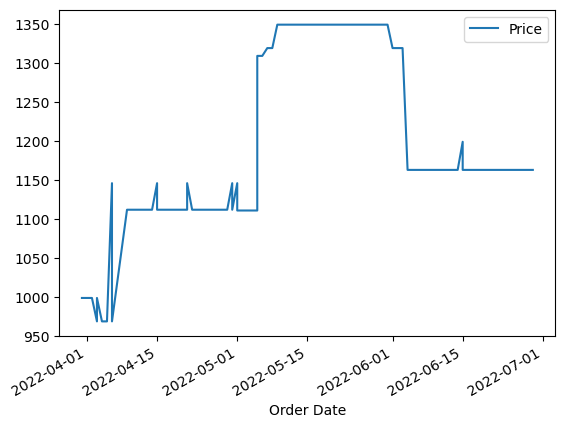

In [64]:
#Checking if records for SKU J0230-SKD-L got populated consistently
sales_data_clean.loc[sales_data_clean['SKU']=='J0230-SKD-L',['Price','Order Date']].drop_duplicates().reset_index(drop=True).plot(x='Order Date')
plt.show()

Missing values seem to have filled in consistently (the 'spikes' around Apr 5, Apr 15, May 1 and June 15 existed before I filled missing data with imputed values)

In [70]:
# Adding column on weekend vs weekday
from datetime import date
sales_data_clean['Weekend'] = sales_data_clean['Order Date'].dt.dayofweek.isin([5,6])
sales_data_clean[['Order Date','Weekend']].drop_duplicates().head()

Order Date  Weekend
0    2022-04-30     True
1481 2022-04-29    False
2947 2022-04-28    False
4363 2022-04-27    False
5822 2022-04-26    False

In [71]:
# Dropping the unnecessary columns
sales_data_final = sales_data_clean.drop(columns = ['Status', 'Courier Status', 'Qty','Amount', 'Shipment State', 'Promotions'])

In [72]:
sales_data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128030 entries, 0 to 128974
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Order ID                128030 non-null  object        
 1   Order Date              128030 non-null  datetime64[ns]
 2   Fulfilment By           128030 non-null  object        
 3   Sales Channel           128030 non-null  object        
 4   Shipment Type           128030 non-null  object        
 5   Style                   128030 non-null  object        
 6   SKU                     128030 non-null  object        
 7   Category                128030 non-null  object        
 8   Size                    128030 non-null  object        
 9   Shipment City           127997 non-null  object        
 10  Shipment Postal Code    128030 non-null  object        
 11  B2B                     128030 non-null  bool          
 12  Easy Ship               128030 non-

In [73]:
# Loading additional data with stock info. My assumption is that customer wait time for order delivery may impact 
# the decision to cancel order. Ideally, I would deduct Cancelation date from Order Date to see how many days 
# customer waited before eciding to cancel. But since I don't have Cancelation date, I'll try to use stock number
# as a proxy of a kind (assuming that when Stock = 0 the wait time will be longer).

stock_data = pd.read_csv('Sale Report.csv')

In [74]:
stock_data.head()

index       SKU Code Design No.  Stock       Category Size Color
0      0    AN201-RED-L      AN201    5.0  AN : LEGGINGS    L   Red
1      1    AN201-RED-M      AN201    5.0  AN : LEGGINGS    M   Red
2      2    AN201-RED-S      AN201    3.0  AN : LEGGINGS    S   Red
3      3   AN201-RED-XL      AN201    6.0  AN : LEGGINGS   XL   Red
4      4  AN201-RED-XXL      AN201    3.0  AN : LEGGINGS  XXL   Red

In [75]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9271 entries, 0 to 9270
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       9271 non-null   int64  
 1   SKU Code    9188 non-null   object 
 2   Design No.  9235 non-null   object 
 3   Stock       9235 non-null   float64
 4   Category    9226 non-null   object 
 5   Size        9235 non-null   object 
 6   Color       9226 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 507.1+ KB


In [76]:
stock_data.drop(columns=['index']).describe()

Stock
count  9235.000000
mean     26.246454
std      58.462891
min       0.000000
25%       3.000000
50%       8.000000
75%      31.000000
max    1234.000000

In [77]:
stock_data.columns

Index(['index', 'SKU Code', 'Design No.', 'Stock', 'Category', 'Size',
       'Color'],
      dtype='object')

In [78]:
merged_data = sales_data_final.merge(stock_data.drop(columns=['index','Design No.','Category','Size','Color']),how='left',left_on='SKU',right_on='SKU Code').drop(columns=['SKU Code'])

In [79]:
merged_data.head()

Order ID Order Date Fulfilment By Sales Channel Shipment Type  \
0  405-8078784-5731545 2022-04-30      Merchant     Amazon.in      Standard   
1  171-9198151-1101146 2022-04-30      Merchant     Amazon.in      Standard   
2  404-0687676-7273146 2022-04-30        Amazon     Amazon.in     Expedited   
3  403-9615377-8133951 2022-04-30      Merchant     Amazon.in      Standard   
4  407-1069790-7240320 2022-04-30        Amazon     Amazon.in     Expedited   

     Style              SKU       Category Size Shipment City  ...  \
0   SET389   SET389-KR-NP-S            Set    S        mumbai  ...   
1  JNE3781  JNE3781-KR-XXXL          kurta  3XL     bengaluru  ...   
2  JNE3371    JNE3371-KR-XL          kurta   XL   navi mumbai  ...   
3    J0341       J0341-DR-L  Western Dress    L    puducherry  ...   
4  JNE3671  JNE3671-TU-XXXL            Top  3XL       chennai  ...   

  Status Category  Price  Shipment State Matched Free Financing  \
0       Cancelled  680.0             Maharashtra          False   
1         Shipped  406.0               Karnataka           True   
2         Shipped  329.0             Maharashtra          False   
3       Cancelled  791.0              Puducherry          False   
4         Shipped  574.0              Tamil Nadu          False   

   Free Shipping Coupon  Other Promotions  No Promotions  Weekend  Stock  
0          False  False             False           True     True   32.0  
1          False  False             False          False     True   96.0  
2           True  False             False          False     True    4.0  
3          False  False             False           True     True  193.0  
4          False  False             False           True     True    6.0  

[5 rows x 23 columns]

In [80]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128030 entries, 0 to 128029
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Order ID                128030 non-null  object        
 1   Order Date              128030 non-null  datetime64[ns]
 2   Fulfilment By           128030 non-null  object        
 3   Sales Channel           128030 non-null  object        
 4   Shipment Type           128030 non-null  object        
 5   Style                   128030 non-null  object        
 6   SKU                     128030 non-null  object        
 7   Category                128030 non-null  object        
 8   Size                    128030 non-null  object        
 9   Shipment City           127997 non-null  object        
 10  Shipment Postal Code    128030 non-null  object        
 11  B2B                     128030 non-null  bool          
 12  Easy Ship               128030

In [81]:
# Stock column has a lot of missing values with no possibility to impute them. If I decide to use this column 
# in my model, I'll need to drop these records. 
merged_data.loc[merged_data['Stock'].isna(),'Status Category'].value_counts()

Status Category
Shipped      6522
Cancelled    1113
Name: count, dtype: int64

In [82]:
# Checking for duplicates after all the transformations
merged_data[merged_data.duplicated()]

Empty DataFrame
Columns: [Order ID, Order Date, Fulfilment By, Sales Channel, Shipment Type, Style, SKU, Category, Size, Shipment City, Shipment Postal Code, B2B, Easy Ship, Status Category, Price, Shipment State Matched, Free Financing, Free Shipping, Coupon, Other Promotions, No Promotions, Weekend, Stock]
Index: []

[0 rows x 23 columns]

In [83]:
# Dropping duplicated record
merged_data.drop_duplicates(inplace=True)

In [84]:
merged_data.dropna(inplace=True)

In [85]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120280 entries, 0 to 128029
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Order ID                120280 non-null  object        
 1   Order Date              120280 non-null  datetime64[ns]
 2   Fulfilment By           120280 non-null  object        
 3   Sales Channel           120280 non-null  object        
 4   Shipment Type           120280 non-null  object        
 5   Style                   120280 non-null  object        
 6   SKU                     120280 non-null  object        
 7   Category                120280 non-null  object        
 8   Size                    120280 non-null  object        
 9   Shipment City           120280 non-null  object        
 10  Shipment Postal Code    120280 non-null  object        
 11  B2B                     120280 non-null  bool          
 12  Easy Ship               120280 non-

# Data profiling for cleaned and merged data

In [7]:
profile = ProfileReport(merged_data, title="Merged Data Profiling Report")

profile 

NameError: name 'merged_data' is not defined

In [86]:
merged_data.to_csv('cancelations_data_clean.csv')